##Configurações

In [1]:
!pip install scikeras==0.12.0
!pip install keras==2.15.0
!pip install tensorflow

  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.
  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Metodos Para Calcular o Theils U Coefficient
def division(measure, previousI):
  return measure / previousI

def power(measure):
  return np.power(measure, 2)

def summation(measure):
  return np.sum(measure)

def mean(N, measure):
  return (1/N) * measure

def sqrt(measure):
  return np.sqrt(measure)

def theil_u2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    N = len(y_true)

    subtractionNumerator = y_pred[1:] - y_true[1:]
    divisionNumerator = division(subtractionNumerator, y_true[:-1])
    powerNumerator = power(divisionNumerator)
    summationNumerator = summation(powerNumerator)
    meanNumerator = mean(N, summationNumerator)
    numerator = sqrt(meanNumerator)

    subtractionDenominator = y_true[1:] - y_true[:-1]
    powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
    denominator = sqrt(mean(N, summation(powerDenominator)))

    theilU2 = numerator / denominator

    return theilU2

## Modelo

In [5]:
dataset = pd.read_csv('/content/drive/My Drive/Projeto Internações/Preparação dos dados/dataset_internacoes_completo.csv')

In [6]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0
2,48,2010-01-01,AC,BRASILÉIA,22325.0
3,2,2010-01-01,AC,BUJARI,8838.0
4,4,2010-01-01,AC,CAPIXABA,9179.0
...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0


In [7]:
dataset['populacao'].dtype

dtype('float64')

In [8]:
def porte(populacao):
  if populacao <= 20000:
    return 'Pequeno Porte I'
  elif populacao >= 20001 and populacao <= 50000 :
    return 'Pequeno Porte II'
  elif populacao >= 50001 and populacao <= 100000:
    return 'Médio Porte'
  elif populacao >= 100001 and populacao <= 900000:
    return 'Grande Porte'
  elif populacao >= 900001:
    return 'Metrópole'

In [9]:
def taxa_internacao (row):
  return row['Qtd. internacoes']*1000/row['populacao']

In [10]:
dataset['taxa_internacao'] = dataset.apply(taxa_internacao, axis =1)

In [11]:
dataset['Porte'] = dataset['populacao'].apply(porte)

In [12]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,taxa_internacao,Porte
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0,1.070255,Pequeno Porte I
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0,1.104972,Pequeno Porte I
2,48,2010-01-01,AC,BRASILÉIA,22325.0,2.150056,Pequeno Porte II
3,2,2010-01-01,AC,BUJARI,8838.0,0.226296,Pequeno Porte I
4,4,2010-01-01,AC,CAPIXABA,9179.0,0.435777,Pequeno Porte I
...,...,...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0,1.212016,Pequeno Porte II
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0,0.621891,Pequeno Porte I
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0,0.466853,Pequeno Porte I
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0,1.069900,Pequeno Porte I


Filtro

In [13]:
dataset = dataset[dataset['Porte'] == 'Grande Porte']

In [14]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,taxa_internacao,Porte
15,275,2010-01-01,AC,RIO BRANCO,350589.0,0.784394,Grande Porte
24,395,2010-01-01,AL,ARAPIRACA,219165.0,1.802295,Grande Porte
169,86,2010-01-01,AM,PARINTINS,104059.0,0.826454,Grande Porte
192,239,2010-01-01,AP,MACAPÁ,412916.0,0.578810,Grande Porte
198,80,2010-01-01,AP,SANTANA,105003.0,0.761883,Grande Porte
...,...,...,...,...,...,...,...
1024727,52,2024-04-01,SP,VALINHOS,109476.0,0.474990,Grande Porte
1024732,42,2024-04-01,SP,VÁRZEA PAULISTA,109780.0,0.382583,Grande Porte
1024738,81,2024-04-01,SP,VOTORANTIM,111543.0,0.726177,Grande Porte
1024752,234,2024-04-01,TO,ARAGUAÍNA,153698.0,1.522466,Grande Porte


In [15]:
time_series = dataset[['Data completa', 'taxa_internacao']]
time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])

<ipython-input-15-8980fe5bf9f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])


In [16]:
time_series = time_series.set_index('Data completa').resample('M').mean()

In [17]:
time_series

,taxa_internacao
Data completa,
2010-01-31,0.848591
2010-02-28,0.819916
2010-03-31,0.868586
2010-04-30,0.855718
2010-05-31,0.868364
...,...
2023-12-31,0.775945
2024-01-31,0.792018
2024-02-29,0.761027


In [18]:
time_series = time_series['2012-1-1':'2024-04-30']

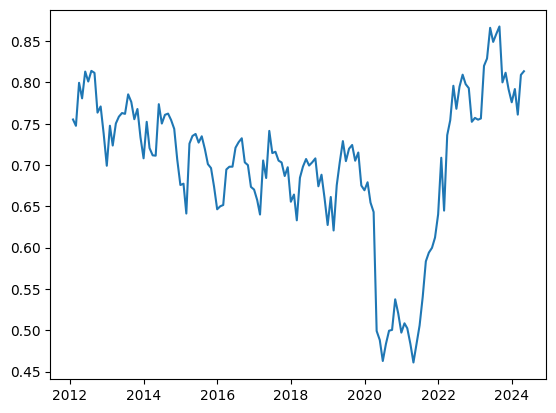

In [19]:
plt.plot(time_series)

In [20]:
time_series

,taxa_internacao
Data completa,
2012-01-31,0.755122
2012-02-29,0.747470
2012-03-31,0.799530
2012-04-30,0.780717
2012-05-31,0.813130
...,...
2023-12-31,0.775945
2024-01-31,0.792018
2024-02-29,0.761027


In [21]:
train_data= time_series.values

#Normaliza os Dados
normalizer = MinMaxScaler(feature_range=(0,1))
train_data = normalizer.fit_transform(train_data)

#Cria os Arrays No Formato Certo
x = []
y = []
for i in range(12, len(train_data)):
  x.append(train_data[i-12:i, 0])
  y.append(train_data[i,0])
x, y = np.array(x), np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1],1))

#Converte os Dados Para Float
x = np.asarray(x).astype('float32')
y = np.asarray(y).astype('float32')


In [22]:
len(x)

136

In [23]:
x_train, y_train = x[:108], y[:108]
x_test, y_test = x[108:], y[108:]



In [24]:
len(x_test)

28

In [25]:
#Cria o Modelo De Rede Neural
dropout_val = 0.2
regressor = Sequential()
regressor.add(LSTM(units = 800, return_sequences = True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 300, return_sequences = True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(dropout_val))

regressor.add(LSTM(units = 200))
regressor.add(Dropout(dropout_val))

regressor.add(Dense(units = 1, activation ='linear'))

regressor.compile(optimizer = 'adam', loss= 'mean_squared_error',
                  metrics = ['mean_squared_error'])


regressor.fit(x_train, y_train, epochs = 100, batch_size=16)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - loss: 0.1845 - mean_squared_error: 0.1845
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - loss: 0.0469 - mean_squared_error: 0.0469
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - loss: 0.0365 - mean_squared_error: 0.0365
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - loss: 0.0267 - mean_squared_error: 0.0267
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 399ms/step - loss: 0.0303 - mean_squared_error: 0.0303
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - loss: 0.0281 - mean_squared_error: 0.0281
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - loss: 0.0248 - mean_squared_error: 0.0248
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.0227 - mean_squared_error: 0.0227
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step - loss: 0.0240 - mean_squared_error: 0.0240
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/s

In [26]:
y_test = y_test.reshape(-1, 1)
train_predictions = regressor.predict(x_test)
train_predictions = normalizer.inverse_transform(train_predictions)
y_test = normalizer.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


In [27]:
train_results = pd.DataFrame(zip(train_predictions, y_test), columns = ['previsao', 'valor_real'])
train_results['previsao'] = train_results['previsao'].apply(lambda x: x[0])
train_results['valor_real'] = train_results['valor_real'].apply(lambda x: x[0])
forecasts = train_results['previsao']
#train_results

In [28]:
start_date = "2022-1-31"
train_results['data'] = pd.date_range(start=start_date, periods=len(train_results), freq='M')
train_results.set_index('data', inplace=True)

In [29]:
train_results

,previsao,valor_real
data,,
2022-01-31,0.638324,0.708828
2022-02-28,0.691582,0.644842
2022-03-31,0.670293,0.736128
2022-04-30,0.696758,0.754235
2022-05-31,0.738606,0.795934
2022-06-30,0.770552,0.768096
2022-07-31,0.757463,0.794810
2022-08-31,0.757897,0.809357
2022-09-30,0.776654,0.797900


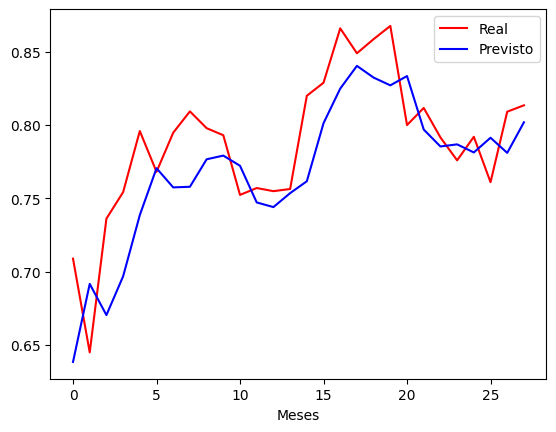

In [30]:
plt.plot(y_test, color='red', label = 'Real')
plt.plot(forecasts, color='blue', label = 'Previsto')
plt.xlabel('Meses')
plt.legend()
plt.show()

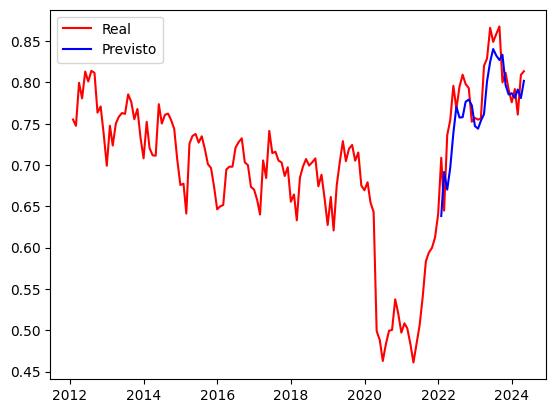

In [31]:
plt.plot(time_series, color='red', label = 'Real')
plt.plot(train_results['previsao'], color='blue', label = 'Previsto')
plt.legend()
plt.show()

In [32]:
mse = mean_squared_error(y_test, forecasts)

In [33]:
mse

0.0012541598

In [34]:
rmse = np.sqrt(mse)

In [35]:
rmse

0.03541412

In [36]:
tu = theil_u2(y_test, forecasts)

In [37]:
tu

0.9379000516638312

In [38]:
# Salva o DataFrame em um arquivo CSV
train_results.to_csv('predicao_previne_brasil_grande_porte_sem_dados_inputados(2012).csv', index=False)